# Predicting NBA Hall of Fame Status

##### CMSC422 Final Project
##### Fall 2022 Teli

Group Members: Prakhar Gupta, Andrew Zhong, Hari Shanmugaraja, Rohit Pasumarthi

In [1]:
import numpy as np, pandas as pd, seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

We import our data from sports-reference.com and barttorvik.com. We use two sources to ensure that we can fill in as much missing data as possible.

`player_data.csv` and `Players.csv` combine to provide us general player data, such as height, weight, college, birth year, and position. `Season_Stats.csv` includes data on players' performances during any given season.

In [2]:
player_data = pd.read_csv('player_data.csv')
players = pd.read_csv('Players.csv')
seasons_stats = pd.read_csv('Seasons_Stats.csv')

In [3]:
player_data.head()

,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,"April 7, 1946",Iowa State University
2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225.0,"April 16, 1947","University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University


In [4]:
players.head()

,Unnamed: 0,Player,height,weight,collage,born,birth_city,birth_state
0,0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN
1,1,Cliff Barker,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
2,2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1924.0,NaN,NaN
3,3,Ed Bartels,196.0,88.0,North Carolina State University,1925.0,NaN,NaN
4,4,Ralph Beard,178.0,79.0,University of Kentucky,1927.0,Hardinsburg,Kentucky


In [5]:
seasons_stats.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


### Data Cleanup

In [6]:
no_player_filter = ~seasons_stats.Player.isnull()
seasons_stats = seasons_stats[no_player_filter]

In [7]:
players = players.rename(columns = {'Unnamed: 0':'id'})

We discovered that there are several distinct players who have the same name as another player. Below, we count the number of rows (players) grouped by name, which returns the number of occurences of each name in `player_data`.

In [8]:
name_freq = player_data.groupby('name').count()

# Pandas creates too many columns, so we just take the first 2
name_freq = name_freq.iloc[:,:1]
name_freq = name_freq.reset_index()
name_freq.columns = ['Player Name', 'Frequency']

# We filter out all rows besides those representing duplicate names
dup_filter = name_freq['Frequency'] > 1
name_freq[dup_filter].head()

,Player Name,Frequency
314,Bill Bradley,2
420,Bob Duffy,2
494,Bobby Jones,2
505,Bobby Wilson,2
680,Cedric Henderson,2


In order to handle this and ensure we keep player data separate, we add a player id column to ensure that each player has a unique identifier.

In [9]:
player_data['id'] = player_data.index

We also added a year born column. When computing this from the `seasons_stats` table we notice that when calculating age by year of play - age for that year, the answers we get are 1 off. Below, we compute the birth year of Michael Jordan and get the year 1964 as our result. If you are an extremely big fan or make a quick Google search, we find that MJ's real birthyear is 1963. This is likely due to the statistics websites taking age at the start of the year, before players have had the chance for their birthdays to pass.

In [10]:
mj_stats = seasons_stats[seasons_stats.Player == 'Michael Jordan*']
mj_stats['Year'].iloc[0] - mj_stats['Age'].iloc[0] 

1964.0

Therefore, we adjust all years born entries down by 1.

In [11]:
seasons_stats['born'] = seasons_stats['Year'] - seasons_stats['Age'] - 1

We now use birth year and player name to join all data, throwing out any records where player born data is missing.

In [12]:
born_missing_filter = ~players.born.isnull()
players = players[born_missing_filter]

born_missing_filter2 = ~player_data.birth_date.isnull()
player_data = player_data[born_missing_filter2]

In [13]:
# Create key of player name and year born with which to join data
players_born = players[['Player', 'born']]

for i, row in player_data.iterrows():
    player_data.loc[i, 'born'] = float(row['birth_date'].split(',')[1])
    
player_data_born = player_data[['name', 'born']]
player_data_born.columns = ['Player', 'born']

born = pd.concat([players_born, player_data_born]).drop_duplicates()

# Create id column
born['id'] = born.index

There were two incorrect birthyears which had to be manually fixed.

In [14]:
hakeem_id = born[born.Player == 'Hakeem Olajuwon*'].id.values[0]
born.loc[hakeem_id, 'born'] = 1962

magic_id = born[born.Player == 'Magic Johnson*'].id.values[0]
born.loc[magic_id, 'born'] = 1959

Here, we merge the data on our player name, year born key `['Player', 'born']` and remove existing aggregate entries.

In [15]:
data = seasons_stats.merge(born, on=['Player', 'born'])

data = data[data.Tm != 'TOT']

Here we count the number of seasons that an individual player has played and then add that to the data

In [16]:
data_season =  data[['id', 'Player', 'Year']].drop_duplicates()
data_season['season']  = data_season.groupby(['id', 'Player']).cumcount() + 1

#we merge this with our original data
data = data.merge(data_season, on=['id', 'Player', 'Year'])

We now perform some feature engineering to produce new features that we strongly believe could be related to HOF status, such as average per-game performance, MVP awards, and championships.

In [17]:
#Extra stats to look at in data
data['PPG'] = data['PTS'] / data['G']
data['APG'] = data['AST'] / data['G']
data['RPG'] = data['TRB'] / data['G']
data['SPG'] = data['STL'] / data['G']
data['BPG'] = data['BLK'] / data['G']

# Adding mvps in case this also increases chance of being a Hall of Famer
mvp_players = {'Bob Pettit*': [1956, 1959],
                  'Bob Cousy*': [1957],
                  'Bill Russell*': [1958, 1961, 1962, 1963, 1965],
                  'Wilt Chamberlain*': [1960, 1966, 1967, 1968],
                  'Oscar Robertson*': [1964],
                  'Wes Unseld*': [1969],
                  'Willis Reed*': [1970],
                  'Kareem Abdul-Jabbar*': [1971, 1972, 1974, 1976, 1977, 1980],
                  'Dave Cowens*': [1973],
                  'Bob McAdoo*': [1975],
                  'Bill Walton*': [1978],
                  'Moses Malone*': [1979, 1982, 1983],
                  'Julius Erving*': [1981],
                  'Larry Bird*': [1984, 1985, 1986],
                  'Magic Johnson*': [1987, 1989, 1990],
                  'Michael Jordan*': [1988, 1991, 1992, 1996, 1998],
                  'Charles Barkley*': [1993],
                  'Hakeem Olajuwon*': [1994],
                  'David Robinson*': [1995],
                  'Karl Malone*': [1997, 1999],
                  'Shaquille O\'Neal*': [2000],
                  'Allen Iverson*': [2001],
                  'Tim Duncan': [2002, 2003],
                  'Kevin Garnett': [2004],
                  'Steve Nash': [2005, 2006],
                  'Dirk Nowitzki': [2007],
                  'Kobe Bryant': [2008],
                  'LeBron James': [2009, 2010, 2012, 2013],
                  'Derrick Rose': [2011],
                  'Kevin Durant': [2014],
                  'Stephen Curry': [2015, 2016],
                  'Russell Westbrook': [2017],
                  'James Harden': [2018]}

data['MVP'] = 0
for i, row in data.iterrows():  
    for k, v in mvp_players.items():
        for year in v:
            if row['Player'] != k:
                break
            elif(row['Year'] == year) & (row['Player'] == k):
                data.loc[i, 'MVP'] = 1
                break

In [18]:
# Adding nba champions in case this also increases chance of being a Hall of Famer
teams_champions = {'BOS': [1957, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1968, 1969, 1974, 1976, 1981, 1984, 1986, 2008],
                  'LAL': [1972, 1980, 1982, 1985, 1987, 1988, 2000, 2001, 2002, 2009, 2010],
                  'MNL': [1949, 1950, 1952, 1953, 1954],
                  'CHI': [1991, 1992, 1993, 1996, 1997, 1998],
                  'GSW': [1975, 2015, 2017, 2018],
                  'PHW': [1947, 1956],
                  'SAS': [1999, 2003, 2005, 2007, 2014],
                  'DET': [1989, 1990, 2004],
                  'MIA': [2006, 2012, 2013],
                  'PHI': [1967, 1983],
                  'SYR': [1955],
                  'HOU': [1994, 1995],
                  'NYK': [1970, 1973],
                  'STL': [1958],
                  'BLB': [1948],
                  'CLE': [2016],
                  'DAL': [2011],
                  'MIL': [1971],
                  'SEA': [1979],
                  'POR': [1977],
                  'ROC': [1951],
                  'WSB': [1978]}

data['Champion'] = 0
for i, row in data.iterrows():  
    for k, v in teams_champions.items():
        for year in v:
            if row['Tm'] != k:
                break
            elif(row['Year'] == year) & (row['Tm'] == k):
                data.loc[i, 'Champion'] = 1
                break

Finally, we want to filter out players that don't achieve at least a certain amount of playing time in a season, as we consider them to not have enough data to be helpful.

In [19]:
# Filter players with at least 800 min in a season
MIN_PLAYTIME = 800

playtime_filter = data.MP > MIN_PLAYTIME
hall_of_fame = data[playtime_filter]

#Create a function so that we can make a column in data, so that it is easier to if a player is in the Hall of Fame
def is_hof(x):
    return '*' in x
    
hall_of_fame['HOF'] = hall_of_fame['Player'].apply(is_hof)

C:\Users\pggup\AppData\Local\Temp\ipykernel_7720\3001583202.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hall_of_fame['HOF'] = hall_of_fame['Player'].apply(is_hof)


In [20]:
# Season 1973 - 1974 : start to count Steals, Blocks and BPM
recency_filter = hall_of_fame.Year >= 1974
hall_of_fame = hall_of_fame[recency_filter]

mvps = data[['id', 'Player', 'MVP']]
mvps['Nb_MVP'] = mvps.groupby('id').cumsum()
mvps = mvps.groupby(['id', 'Player'], sort=False)['Nb_MVP'].max().reset_index()

mvps.sort_values(by='Nb_MVP', ascending=False).head(10)

C:\Users\pggup\AppData\Local\Temp\ipykernel_7720\1252094271.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.cumsum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mvps['Nb_MVP'] = mvps.groupby('id').cumsum()
C:\Users\pggup\AppData\Local\Temp\ipykernel_7720\1252094271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mvps['Nb_MVP'] = mvps.groupby('id').cumsum()


,id,Player,Nb_MVP
707,789,Kareem Abdul-Jabbar*,6
1509,1675,Michael Jordan*,5
386,438,Bill Russell*,5
2681,2944,LeBron James,4
2350,494,Gerald Brown,4
437,494,Wilt Chamberlain*,4
1061,1185,Moses Malone*,3
1222,1366,Magic Johnson*,3
1199,1341,Larry Bird*,3
1566,1737,Karl Malone*,2


In [21]:
champions = data[['id', 'Player', 'Champion']]
champions['Total_Champion'] = champions.groupby('id').cumsum()
champions = champions.groupby(['id', 'Player'], sort=False)['Total_Champion'].max().reset_index()
champions.sort_values(by='Total_Champion', ascending=False).head(10)

C:\Users\pggup\AppData\Local\Temp\ipykernel_7720\2024852811.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.cumsum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  champions['Total_Champion'] = champions.groupby('id').cumsum()
C:\Users\pggup\AppData\Local\Temp\ipykernel_7720\2024852811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  champions['Total_Champion'] = champions.groupby('id').cumsum()


,id,Player,Total_Champion
386,438,Bill Russell*,11
399,453,Sam Jones*,10
424,480,K.C. Jones*,8
466,526,Tom Sanders*,8
514,578,John Havlicek*,8
377,427,Tom Heinsohn*,8
1989,2203,Robert Horry,7
356,405,Jim Loscutoff,7
335,380,Frank Ramsey*,7
206,233,Bob Cousy*,6


In [22]:
nb_seasons = data_season[['id', 'Player', 'season']]
nb_seasons = nb_seasons.groupby(['id', 'Player'], sort=False)['season'].max().reset_index()
nb_seasons.sort_values(by='season', ascending=False).head(10)

,id,Player,season
1536,4426,Kevin Willis,21
1070,1195,Robert Parish*,21
2170,2401,Kevin Garnett,21
2224,2456,Kobe Bryant,20
707,789,Kareem Abdul-Jabbar*,20
1575,1747,Charles Oakley,19
1116,1248,James Edwards,19
1566,1737,Karl Malone*,19
2388,2630,Paul Pierce,19
1061,1185,Moses Malone*,19


In [23]:
last_season = hall_of_fame[['id', 'Player', 'Year']]
last_season = last_season.groupby(['id', 'Player'], sort=False)['Year'].max().reset_index()
last_season.columns = ['id', 'Player', 'Last_Season']

total_points = data[['Player', 'PTS', 'id']].groupby(['id', 'Player']).sum()
total_points = total_points.reset_index()
total_points.columns = ['id', 'Player', 'Total_PTS']

In [24]:
career = hall_of_fame.groupby(['id', 'Player']).mean()
career = career.reset_index()
career.head()

C:\Users\pggup\AppData\Local\Temp\ipykernel_7720\106354038.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  career = hall_of_fame.groupby(['id', 'Player']).mean()


,id,Player,Unnamed: 0,Year,Age,G,GS,MP,PER,TS%,...,born,season,PPG,APG,RPG,SPG,BPG,MVP,Champion,HOF
0,3,Mahmoud Abdul-Rauf,11386.142857,1994.000000,24.000000,73.428571,48.000000,2087.428571,15.242857,0.507857,...,1969.0,4.000000,15.777782,3.880602,2.002227,0.907202,0.084110,0.0,0.000000,0.0
1,44,Courtney Alexander,15496.666667,2002.000000,24.000000,49.666667,17.666667,1198.333333,12.366667,0.499667,...,1977.0,2.000000,11.563592,1.417068,2.464566,0.722924,0.096661,0.0,0.000000,0.0
2,58,Ray Allen,17385.052632,2005.368421,29.368421,68.421053,60.473684,2439.157895,18.526316,0.581474,...,1975.0,9.368421,19.124945,3.452787,4.118728,1.137763,0.185133,0.0,0.105263,0.0
3,74,David Andersen,19934.000000,2010.000000,29.000000,63.000000,0.000000,891.000000,12.100000,0.497000,...,1980.0,1.000000,5.825397,0.698413,3.301587,0.238095,0.190476,0.0,0.000000,0.0
4,146,D.J. Augustin,21501.375000,2012.625000,24.625000,68.875000,23.625000,1681.625000,13.837500,0.537250,...,1987.0,4.625000,10.214707,4.143085,1.836157,0.607843,0.035776,0.0,0.000000,0.0


In [25]:
career_num = career[['id', 'Player', 'PER', 'TS%', 'OWS', 'DWS', 
                     'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 
                     'FG%', '3P%', '2P%', 'eFG%', 'FT%', 
                     'PPG', 'APG', 'RPG', 'SPG', 'BPG', 'HOF']]

career_num = career_num.merge(mvps, on=['id', 'Player'])
career_num = career_num.merge(champions, on=['id', 'Player'])
career_num = career_num.merge(nb_seasons, on=['id', 'Player'])
career_num = career_num.merge(last_season, on=['id', 'Player'])
career_num = career_num.merge(total_points, on=['id', 'Player'])

career_num.head()

,id,Player,PER,TS%,OWS,DWS,WS,WS/48,OBPM,DBPM,...,APG,RPG,SPG,BPG,HOF,Nb_MVP,Total_Champion,season,Last_Season,Total_PTS
0,3,Mahmoud Abdul-Rauf,15.242857,0.507857,2.385714,1.171429,3.528571,0.072714,0.800000,-3.057143,...,3.880602,2.002227,0.907202,0.084110,0.0,0,0,9,1997.0,8553.0
1,44,Courtney Alexander,12.366667,0.499667,0.866667,0.566667,1.400000,0.056000,-1.333333,-2.266667,...,1.417068,2.464566,0.722924,0.096661,0.0,0,0,3,2003.0,1690.0
2,58,Ray Allen,18.526316,0.581474,5.873684,1.757895,7.642105,0.149263,4.205263,-1.247368,...,3.452787,4.118728,1.137763,0.185133,0.0,0,2,18,2014.0,24505.0
3,74,David Andersen,12.100000,0.497000,0.400000,0.900000,1.300000,0.070000,-2.500000,-1.300000,...,0.698413,3.301587,0.238095,0.190476,0.0,0,0,2,2010.0,501.0
4,146,D.J. Augustin,13.837500,0.537250,2.300000,1.162500,3.437500,0.094500,0.812500,-2.625000,...,4.143085,1.836157,0.607843,0.035776,0.0,0,0,9,2017.0,6214.0


In [26]:
career_num = career_num.fillna(0)

career_num = career_num.drop(['Player'], axis=1)

In [27]:
# Looking at the features correlations with HOF
career_num.corr()['HOF'].sort_values(ascending=False)

HOF               1.000000
Total_PTS         0.471363
WS                0.389546
PPG               0.365606
OWS               0.354728
PER               0.323333
DWS               0.315797
Nb_MVP            0.315343
BPM               0.290873
WS/48             0.285238
Total_Champion    0.280929
OBPM              0.277936
season            0.240575
RPG               0.234286
SPG               0.204839
APG               0.202173
BPG               0.166891
FG%               0.135673
TS%               0.120102
2P%               0.095232
DBPM              0.088586
FT%               0.074549
eFG%              0.059544
3P%              -0.089724
Last_Season      -0.172186
id               -0.224112
Name: HOF, dtype: float64

# Predicion Models

Now that we are done setting up our dataset, we can train various models to predict future hall of fame status for current NBA players, as well as compare how well different models perform against each other. First, we will split our data into training and inference datasets. We only consider players that have been eligible for hall of fame status for long enough or have already achieved hall of fame status to be suitable training data, as otherwise we may get players that have retired recently and are hall of fame-worthy but just haven't had the chance to receive the honor yet. Our inference data is only players that are currently still active or have retired recently and have not yet had the chance to receive hall of fame status.

We then use sklearn's train_test_split function to split our train dataset into train and test subsections for model evaluation purposes.

In [28]:
train = career_num[(career_num.Last_Season <= 1997) | (career_num.HOF == 1)]
test = career_num[(career_num.Last_Season > 1997) & (career_num.HOF == 0)]

X = train.drop('HOF', axis=1)
y = train['HOF']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_infer = test.drop('HOF', axis=1)

## SVM
We first attempted to use an SVM for prediction. Since SVMs are extremely powerful at binary classification, we expected and achieved high accuracy on the test dataset. We then used the SVM to produce probabilities for each future HOF-eligible player to achieve HOF status, and sorted players by probability.

In [29]:
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [30]:
print(f"The SVM achieved {svm.score(X_train, y_train) * 100}% accuracy on the train dataset and {svm.score(X_test, y_test) * 100}% accuracy on the test dataset.")

The SVM achieved 94.6843853820598% accuracy on the train dataset and 94.70198675496688% accuracy on the test dataset.


In [31]:
svm_pred_proba = svm.predict_proba(X_infer)
svm_y_pred_proba = []
for i in enumerate(svm_pred_proba):
    svm_y_pred_proba.append(i[1][1])
svm_y_pred_proba = np.asarray(svm_y_pred_proba)

svm_results_hof = pd.DataFrame({
    "id": test["id"],
    "HOF": svm_y_pred_proba
    })

As you'd expect, successful players like Lebron James, Tim Duncan, and Kobe Bryant were at the top of the HOF list, which goes to show that the SVM model fits our expectations for which current players should be inducted to the Hall of Fame in the future.

In [32]:
career_player = career[['id', 'Player']]
svm_results_hof = career_player.merge(svm_results_hof, on='id')

svm_results_hof = svm_results_hof.sort_values(by='HOF', ascending=False)
svm_results_hof = svm_results_hof.head(20)
svm_results_hof

,id,Player,HOF
531,2944,LeBron James,1.000000
301,2535,Tim Duncan,1.000000
266,2456,Kobe Bryant,1.000000
357,2626,Dirk Nowitzki,0.999994
245,2401,Kevin Garnett,0.995212
606,3096,Chris Paul,0.993118
665,3220,Kevin Durant,0.992921
360,2630,Paul Pierce,0.974051
455,2808,Pau Gasol,0.970750
727,3343,Stephen Curry,0.962520


Below, we visualized the same data using a Seaborn bar chart, with each bar representing a player's probability of being inducted into the Hall of Fame given their current career.

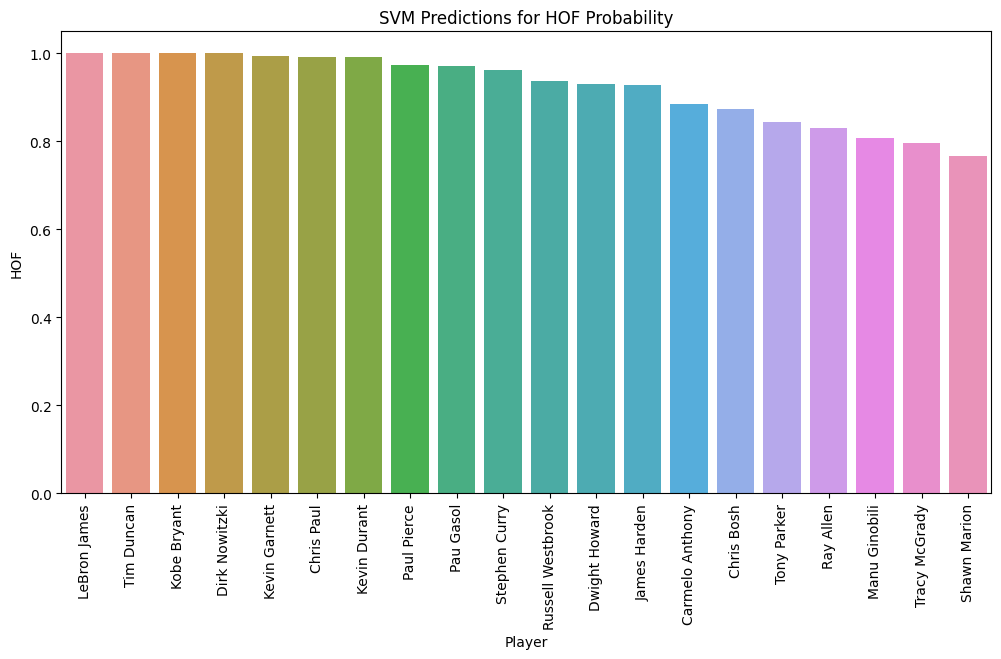

In [33]:
plt.figure(figsize=(12,6))
g = sns.barplot(x = svm_results_hof.Player, y = svm_results_hof.HOF)
g.set_xticklabels(labels = svm_results_hof.Player,  rotation=90)
plt.title('SVM Predictions for HOF Probability')
plt.show()

## Neural Networks

## Decision Tree

Next we attempted a decision tree

In [34]:
from sklearn import tree
from sklearn.model_selection import train_test_split
# train : older players who stop playing 20+ years ago (last data year is 2017 so 1997)
train = career_num[(career_num.Last_Season <= 1997) | (career_num.HOF == 1)]
test = career_num[(career_num.Last_Season > 1997) & (career_num.HOF == 0)]

X_train = train.drop('HOF', axis=1)
y_train = train['HOF']
X_test = test.drop('HOF', axis=1)

[Text(0.691825259515571, 0.9545454545454546, 'X[24] <= 14035.5\ngini = 0.177\nsamples = 753\nvalue = [679, 74]'),
 Text(0.5358996539792388, 0.8636363636363636, 'X[4] <= 3.924\ngini = 0.057\nsamples = 680\nvalue = [660, 20]'),
 Text(0.43166089965397925, 0.7727272727272727, 'X[1] <= 19.08\ngini = 0.041\nsamples = 672\nvalue = [658, 14]'),
 Text(0.3062283737024221, 0.6818181818181818, 'X[0] <= 735.5\ngini = 0.03\nsamples = 666\nvalue = [656, 10]'),
 Text(0.1384083044982699, 0.5909090909090909, 'X[0] <= 719.0\ngini = 0.264\nsamples = 32\nvalue = [27, 5]'),
 Text(0.11072664359861592, 0.5, 'X[6] <= 0.162\ngini = 0.18\nsamples = 30\nvalue = [27, 3]'),
 Text(0.08304498269896193, 0.4090909090909091, 'X[9] <= -2.286\ngini = 0.128\nsamples = 29\nvalue = [27, 2]'),
 Text(0.05536332179930796, 0.3181818181818182, 'X[8] <= -0.708\ngini = 0.408\nsamples = 7\nvalue = [5, 2]'),
 Text(0.02768166089965398, 0.22727272727272727, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.08304498269896193, 0.227272

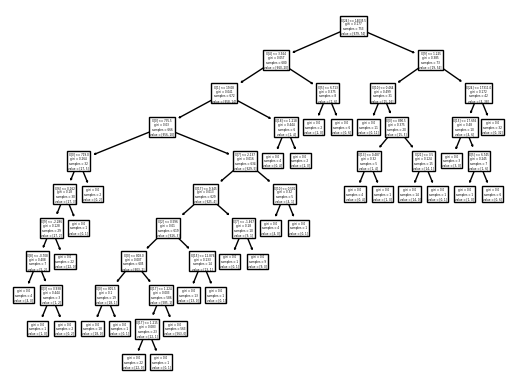

In [35]:
# Decision Tree

dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
dt.score(X_train, y_train)
acc_dt = round(dt.score(X_train, y_train) * 100, 2)

tree.plot_tree(dt)

In the Code above, we use sklearns tree in order to train a decision tree. As you can see above, the tree is fairly large due to the amount of variables it has to consider in order to get to its result.

In [36]:
pred_proba = dt.predict_proba(X_test)

y_pred_proba = []
for i in enumerate(pred_proba):
    y_pred_proba.append(i[1][1])
y_pred_proba = np.asarray(y_pred_proba)

results_hof = pd.DataFrame({
    "id": test["id"],
    "HOF": y_pred_proba
    })


career_player = career[['id', 'Player']]
results_hof = career_player.merge(results_hof, on='id')

results_hof = results_hof.sort_values(by='HOF', ascending=False)
results_hof = results_hof.head(20)
results_hof

,id,Player,HOF
183,2234,Latrell Sprewell,1.0
653,3188,Brandon Roy,1.0
245,2401,Kevin Garnett,1.0
847,3570,Damian Lillard,1.0
803,3464,Kenneth Faried,1.0
357,2626,Dirk Nowitzki,1.0
341,2607,Antawn Jamison,1.0
718,3325,Russell Westbrook,1.0
140,2113,Jayson Williams,1.0
243,2399,Rashard Lewis,1.0


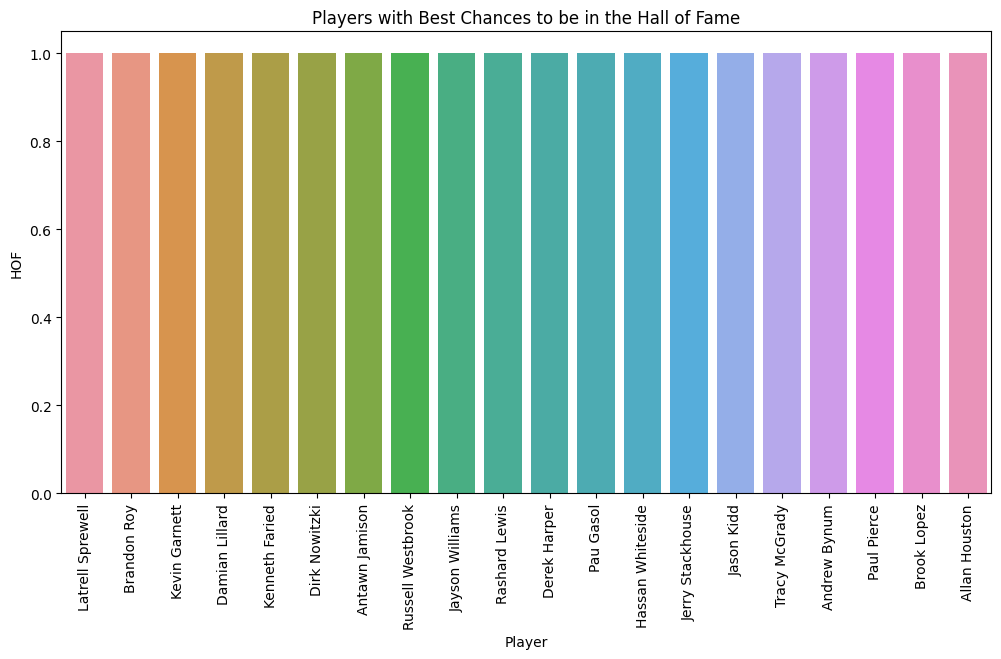

In [37]:
plt.figure(figsize=(12,6))
g = sns.barplot(x = results_hof.Player, y = results_hof.HOF)
g.set_xticklabels(labels = results_hof.Player,  rotation=90)
plt.title('Players with Best Chances to be in the Hall of Fame')
plt.show()

Looking at our end results for the decision tree, we can see that while we do get a result for who will and who will not be in the Hall of Fame, these results don't give us anything that can be used beyond just 'yes' or 'no'. With the other classifiers, we get a percentage chance for Hall of Fame status, which is a much more useful metric to evaluate who potential Hall of Famers. Simply know whether or not some can make it to the Hall of Fame will not help a company choose a potential player to sponsor, whereas knowing a player has 92% chance to make it to the Hall of Fame definitely will help a company choose. This goes to show that not all classifiers are going to provide results that matter for all types of problems. In this case, while a decision tree does the job, it just doesn't perform at the same level as the three other algorithms, because there's no way to really compare the results from the Decision Tree.

For further reading into why Decision Trees are not optimal, the link:( https://careerfoundry.com/en/blog/data-analytics/what-is-a-decision-tree/#:~:text=Disadvantages%20of%20decision%20trees,-Overfitting%20(where%20a&text=They%20are%20not%20well%2Dsuited,path%20includes%20many%20chance%20variables. ), was very informative for me when I was trying to interpret the results of the decision tree. 

## KNN